# Úkol č. 2 - předzpracování dat a binární klasifikace (do 7. prosince)

  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na trénovací, testovací a případně i validační množinu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí testovací množiny. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor(y) s predikcemi pro vyhodnocovací data.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [63]:
"""
Fills custom pandas DataFrame. 
Added new columns: 
    - survived
    - family
    - familysize
    - surname
    - title
    
Removed columns:
    - cabin (too many are missing to be filled)
    - ticket
    - home.dest

Parameters
----------
first : pandas.DataFrame
     data frame filled with input csv data
second : bool, optional
        True (default) when adding the "survived" (vector Y) column
        
Returns
-------
pandas.DataFrame
    data frame with all data from input dataset along with some new empty columns
"""
def feature_selection(dataset, survived = True):
    columns_to_drop = ['cabin','ticket','home.dest']
    data = pd.DataFrame(dataset)
    data = pd.concat([data,pd.DataFrame(columns=['survived', 'family', 'familysize', 'title'])], sort=False)
    if(survived):
        data.survived = dataset.survived
    else:
        columns_to_drop.append('survived')
 
    data.drop(columns=columns_to_drop,inplace=True)
    display(data.head())
    return data

In [64]:
"""
Displays countplot of Y vector ("survived" column) dependency on given feature.

Parameters
----------
first : bool
        True if "survived" column is present in dataset
second: string
        column name of feature we want to see in graph
third : pandas.DataFrame
        data
"""
def plot_survived_column_dependency(survived, column, data):
        if(survived):
            plt.plot(figsize=(10,5))
            sns.countplot(x=column, hue="survived", data=data, palette='viridis')
            plt.show()

In [65]:
"""
Transformation of 'fare' feature:
    - filled NaN values
    - values split into 5 categories by interval

Parameters
----------
first : bool
        True (default) "survived" column is present in dataset
second: string
        column name of feature
third : pandas.DataFrame
        data
Returns
-------
pandas.Series
    transformed feature vector       
"""           
def fare_feature(survived, column, data):
    col = data[column]
    medianFare = col.median()
    print("Median Fare: ", medianFare)
    col.fillna(medianFare,inplace=True)
    
    plot_survived_column_dependency(survived, "pclass", data)
    #fare into categories => similiar to pclass
    maxFare = col.max()
    minFare = col.min()
    print("Max Fare: ", maxFare)
    print("Min Fare: ", minFare)
    if(survived):
        plt.plot(figure=(10,10))
        plt.scatter(x=data.index, y=data.fare)
        plt.show()
    #<35 (0), <70(1), <100 (2), <200(3), <more(4)
    col = col.apply(lambda x: 0 if x<35 else x)
    col = col.apply(lambda x: 1 if (x>=35 and x<70) else x)
    col = col.apply(lambda x: 2 if (x>=70 and x<100) else x)
    col = col.apply(lambda x: 3 if (x>=100 and x<200) else x)
    col = col.apply(lambda x: 4 if (x>=200) else x)
    col = col.astype(int)
    
    data[column] = col
    plot_survived_column_dependency(survived, column, data)
    return col

In [66]:
"""
Transformation and extraction of family related features:
    - new familysize feature -> 4 categories
    - new family feature -> family affiliation

Parameters
----------
first : bool
        True (default) "survived" column is present in dataset
third : pandas.DataFrame
        data
Returns
-------
pandas.DataFrame
    transformed data frame
"""
def family_features(survived, data):
    #number of family peers + children a parents
    data.familysize = data.parch + data.sibsp
    plot_survived_column_dependency(survived, "familysize", data)
    #bez rodiny umiraji nejvice, 1 az 3 nejmene, 7 a vice na sto procent
    data.familysize = data.familysize.apply(lambda x: 0 if x==0 else x)
    data.familysize = data.familysize.apply(lambda x: 1 if (x>=1 and x<4) else x)
    data.familysize = data.familysize.apply(lambda x: 2 if (x>=4 and x<7) else x)
    data.familysize = data.familysize.apply(lambda x: 3 if x>=7 else x)
    data.familysize = data.familysize.astype(int)
    plot_survived_column_dependency(survived, "familysize", data)
    #extracting surnames from name
    surnames = data.name.map(lambda x: x.split(',')[0]).map(lambda x: x.split('-')[0])
    uniq_snames = np.array(surnames.unique())
    maxsur  = uniq_snames.size
    print("Unique surnames [#]: ",maxsur)

    #creating family affiliation feature
    data.family = surnames
    data.family = data.family.apply(lambda x: [i for i, e in enumerate(uniq_snames) if e == x][0])
    #for passenger without families we create an unique value
    for row in range(0, data.sex.size):
        row2 = data.iloc[[row]]
        familySize = row2.familysize
        if(familySize.item() < 1 ):
            row2.family = maxsur
            data.iloc[[row]] = row2
            maxsur += 1

    return data

In [67]:
"""Extracting title from a list of names"""
def getTitle(names):
    parts = names.map(lambda x: x.split(',')[1])
    titles = parts.map(lambda x: x.split('.')[0])
    titles = titles.map(lambda x: x.split(' ')[1])
    print(titles.unique())
    return titles

"""Transformation of 'title' feature -> attempt at describing passengers' importance

Parameters
----------
first : bool
        True (default) "survived" column is present in dataset
second: string
        column name of feature
third : pandas.DataFrame
        data
Returns
-------
pandas.Series
    transformed feature vector  """ 
def title_features(survived, column, data):
    #spolecensky titul - muze urcit roli pasazera na lodi
    arrayT = getTitle(data.name)
    data[column] = arrayT
    arrayT_indx = arrayT.unique()
    k = 0
    for x in arrayT_indx:
        data[column] = data[column].replace(x, k)
        k+=1
        
    data[column]= data[column].apply(lambda x: arrayT_indx.size if x not in range(0,arrayT_indx.size) else x)
    plot_survived_column_dependency(survived, column, data)
    return data[column]
    

In [68]:
"""Transformation of 'age' feature:
    - filled NaN values
    - values split into 5 categories by interval

Parameters
----------
first : bool
        True (default) "survived" column is present in dataset
second: string
        column name of feature
third : pandas.DataFrame
        data
Returns
-------
pandas.Series
    transformed feature vector       """ 
def age_feature(survived, column, data):
    age = data[column]
    medianAge = age.median()
    print("Median Age: ", medianAge)
    meanAge = age.mean()
    print("Mean Age: ", meanAge)
    age.fillna(medianAge,inplace=True)
    maxAge = age.max()
    minAge = age.min()
    print("Max age: ", maxAge)
    print("Min age: ", minAge)
    if(survived):
        plt.plot(figure=(10,10))
        plt.scatter(x=data.index, y=age)
        plt.show()
    #deti, mladistvi, mladi, stredni vek, stari
    age = age.apply(lambda x: 0 if x<10 else x)
    age = age.apply(lambda x: 1 if (x>=10 and x<18) else x)
    age = age.apply(lambda x: 2 if (x>=18 and x<30) else x)
    age = age.apply(lambda x: 3 if (x>=30 and x<55) else x)
    age = age.apply(lambda x: 4 if (x>=55) else x)
    age = age.astype(int)
    data[column] = age
    plot_survived_column_dependency(survived, column, data)
    
    return data[column]

In [69]:
"""
Feature extraction: 
    - filled NaN values
    - features with too many values split into intervals
    - text values changed to integers

Parameters
----------
first : bool
        True (default) "survived" column is present in dataset
second: string
        column name of feature
third : pandas.DataFrame
        data
Returns
-------
pandas.Series
    transformed feature vector       
""" 
def feature_extraction(data, survived):    
    data.sex = data.sex.astype('category')
    data.sex = data.sex.cat.codes
    
    data.fare = fare_feature(survived, "fare", data)

    data = family_features(survived, data)
    
    data.title = title_features(survived, "title", data)
    data.drop(columns=['name'], inplace=True)

    data.age = age_feature(survived, "age", data)
   
    #filling nans in embarked
    data.embarked.fillna(data.embarked.mode(),inplace=True)
    #change values to numbers
    data.embarked = data.embarked.astype('category')
    data.embarked = data.embarked.cat.codes
    data.embarked = data.embarked.apply(lambda x: 4 if x not in [0,1,2,3] else x)
    #plotting dependency
    plot_survived_column_dependency(survived, "embarked", data)

    return data
    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
ID           1000 non-null int64
survived     1000 non-null int64
pclass       1000 non-null int64
name         1000 non-null object
sex          1000 non-null object
age          796 non-null float64
sibsp        1000 non-null int64
parch        1000 non-null int64
ticket       1000 non-null object
fare         999 non-null float64
cabin        229 non-null object
embarked     999 non-null object
home.dest    575 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 101.6+ KB
Data loaded from CSV:


,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,"Dorchester, MA"
1,1,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,"Winnipeg, MB"
2,2,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,NaN
3,3,0,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S,NaN
4,4,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S,NaN


,ID,survived,pclass,name,sex,age,sibsp,parch,fare,embarked,family,familysize,title
0,0.0,0,1.0,"McCarthy, Mr. Timothy J",male,54.0,0.0,0.0,51.8625,S,NaN,NaN,NaN
1,1.0,0,1.0,"Fortune, Mr. Mark",male,64.0,1.0,4.0,263.0000,S,NaN,NaN,NaN
2,2.0,1,1.0,"Sagesser, Mlle. Emma",female,24.0,0.0,0.0,69.3000,C,NaN,NaN,NaN
3,3.0,0,3.0,"Panula, Master. Urho Abraham",male,2.0,4.0,1.0,39.6875,S,NaN,NaN,NaN
4,4.0,1,1.0,"Maioni, Miss. Roberta",female,16.0,0.0,0.0,86.5000,S,NaN,NaN,NaN


Median Fare:  14.4583


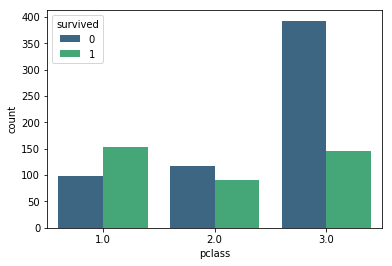

Max Fare:  512.3292
Min Fare:  0.0


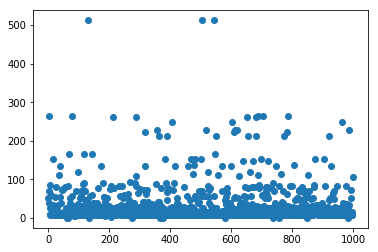

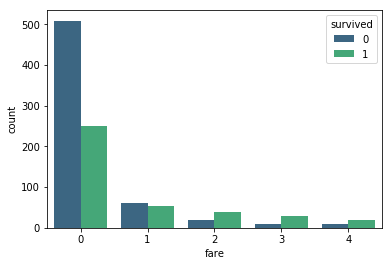

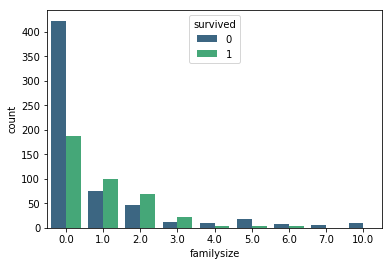

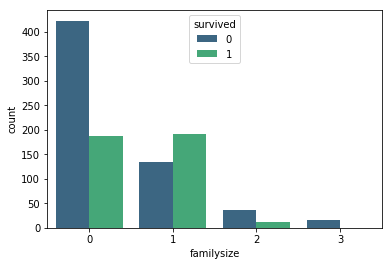

Unique surnames [#]:  712
['Mr' 'Mlle' 'Master' 'Miss' 'Mrs' 'Ms' 'Dr' 'Capt' 'Rev' 'Mme' 'Major'
 'Lady' 'Col' 'Don' 'Dona' 'the' 'Jonkheer']


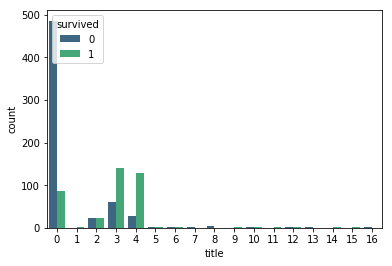

Median Age:  28.0
Mean Age:  29.802345100502514
Max age:  80.0
Min age:  0.1667


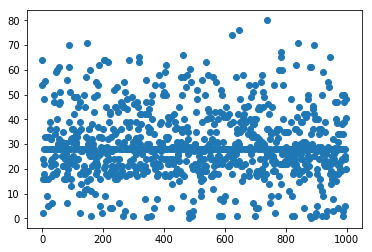

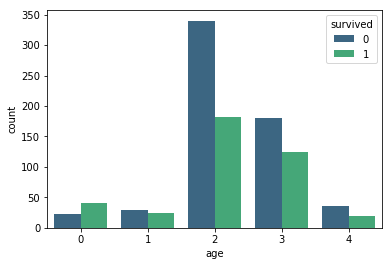

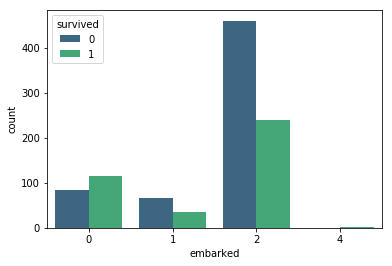

Data after FS and FE:


,ID,survived,pclass,sex,age,sibsp,parch,fare,embarked,family,familysize,title
0,0.0,0,1.0,1,3,0.0,0.0,1,2,712,0,0
1,1.0,0,1.0,1,4,1.0,4.0,4,2,1,2,0
2,2.0,1,1.0,0,2,0.0,0.0,1,0,713,0,1
3,3.0,0,3.0,1,0,4.0,1.0,1,2,3,2,2
4,4.0,1,1.0,0,1,0.0,0.0,2,2,714,0,3


In [70]:
#----loading data set
data = pd.read_csv('data.csv')
data.info()
print("Data loaded from CSV:")
display(data.head())

dataFE = pd.DataFrame()
survived = 1
data_selected = feature_selection(data, survived)
dataFE = feature_extraction(data_selected, survived)
print("Data after FS and FE:")
display(dataFE.head())



In [71]:
#keeping index values
labels = dataFE.index.values
#split to train a validation sets
data_train, data_test, labels_train, labels_test = train_test_split(dataFE, labels, test_size=0.20, random_state=26)

y_train = data_train.survived
y_true = np.array(data_test.survived)

In [72]:
data_test.drop(columns=['survived'], inplace=True)
data_train.drop(columns=['survived'], inplace=True)

print(data_train.shape)
print(data_test.shape)

Y_train = dataFE.survived
X_train = dataFE.drop(columns=['survived'], axis=1)

(800, 11)
(200, 11)


/home/girlingreyshirt/.local/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Predikce s logistickou regresí


In [73]:
clfReg = LogisticRegression(solver='liblinear')
# fit on train data
clfReg.fit(data_train,y_train)
print("Train presnost (score): ",clfReg.score(data_train, y_train))
# predict on validation set
y_pred = clfReg.predict(data_test)
""" Manual accuracy score on validation data"""
sc = 0
for x in range(0,200):
    a = y_pred[x]
    b = y_true[x]
    if(a != b):
        sc += 1
print("Test presnost (manual): ", 1 - sc/y_true.size)

print("Test presnost (score): ",clfReg.score(data_test, y_true))


from sklearn.model_selection import cross_val_score
clf2 = LogisticRegression(solver='liblinear')
rounds = 10
accuracy = cross_val_score(clf2, X_train, Y_train, cv = rounds)
print("LogReg: Validace - prumer: ", accuracy.mean())

Train presnost (score):  0.81875
Test presnost (manual):  0.8049999999999999
Test presnost (score):  0.805
LogReg: Validace - prumer:  0.8079056905690569


### Predikce Multinom.Naivní Bayes

In [74]:
#---------Naivni Bayes
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(data_train,y_train)
print("Train presnost (score): ",clf.score(data_train, y_train))
y_pred = clf.predict(data_test)

print("Test presnost (score): ",clf.score(data_test, y_true))

clf2 = MultinomialNB()
accuracy = cross_val_score(clf2, X_train, Y_train, cv = rounds)
print("NB: Validace - prumer: ", accuracy.mean())


Train presnost (score):  0.635
Test presnost (score):  0.635
NB: Validace - prumer:  0.6077503750375037


### Predikce podle k nejbližších sousedů

In [88]:
#---------KNN
from sklearn.neighbors import KNeighborsClassifier
k = š

clf = KNeighborsClassifier(k)
clf.fit(data_train,y_train)
print("Train presnost (score): ",clf.score(data_train, y_train))
y_pred = clf.predict(data_test)
print("Test presnost (score): ",clf.score(data_test, y_true))

clf2 = KNeighborsClassifier(k)
accuracy = cross_val_score(clf2, X_train, Y_train, cv = rounds)
print("KNN: Validace - prumer presnosti: ", accuracy.mean())

NameError: name 'š' is not defined

### Predikce nad evaluačním datasetem

In [76]:
#----loading evaluation set
data = pd.read_csv('evaluation.csv')
data.info()

dataFE = pd.DataFrame()
survived = 0
data_selected = feature_selection(data, survived)
dataFE = feature_extraction(data_selected, survived)

display(dataFE.head())
print(dataFE.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 12 columns):
ID           309 non-null int64
pclass       309 non-null int64
name         309 non-null object
sex          309 non-null object
age          250 non-null float64
sibsp        309 non-null int64
parch        309 non-null int64
ticket       309 non-null object
fare         309 non-null float64
cabin        66 non-null object
embarked     308 non-null object
home.dest    170 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 29.0+ KB


,ID,pclass,name,sex,age,sibsp,parch,fare,embarked,family,familysize,title
0,1000.0,2.0,"Navratil, Master. Edmond Roger",male,2.0,1.0,1.0,26.0000,S,NaN,NaN,NaN
1,1001.0,3.0,"Windelov, Mr. Einar",male,21.0,0.0,0.0,7.2500,S,NaN,NaN,NaN
2,1002.0,2.0,"Myles, Mr. Thomas Francis",male,62.0,0.0,0.0,9.6875,Q,NaN,NaN,NaN
3,1003.0,1.0,"Fortune, Miss. Ethel Flora",female,28.0,3.0,2.0,263.0000,S,NaN,NaN,NaN
4,1004.0,3.0,"Toufik, Mr. Nakli",male,NaN,0.0,0.0,7.2292,C,NaN,NaN,NaN


Median Fare:  14.4542
Max Fare:  512.3292
Min Fare:  0.0
Unique surnames [#]:  275


/home/girlingreyshirt/.local/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


['Master' 'Mr' 'Miss' 'Dr' 'Mrs' 'Rev' 'Sir' 'Mlle']
Median Age:  28.25
Mean Age:  30.132
Max age:  70.5
Min age:  0.75


,ID,pclass,sex,age,sibsp,parch,fare,embarked,family,familysize,title
0,1000.0,2.0,1,0,1.0,1.0,0,2,0,1,0
1,1001.0,3.0,1,2,0.0,0.0,0,2,275,0,1
2,1002.0,2.0,1,4,0.0,0.0,0,1,276,0,1
3,1003.0,1.0,0,2,3.0,2.0,4,2,3,2,2
4,1004.0,3.0,1,2,0.0,0.0,0,0,277,0,1


(309, 11)


In [87]:
#-------LogReg had best results on validation data -> thus I'm using it for test data as well

#model already trained on training data
y_res = clfReg.predict(dataFE)

out = pd.DataFrame()
out["predikce přežití"] = y_res

"""Setting index"""
out["ID"] = np.array(range(0,y_res.shape[0])) + 1000
out = out.set_index(["ID"])

display(out.head(10))
out.to_csv("results.csv", sep=',')

,predikce přežití
ID,
1000,1
1001,0
1002,0
1003,1
1004,0
1005,0
1006,0
1007,1
1008,0
